In [3]:
import numpy as np
import pandas as pd
import multiprocessing

import matplotlib.pyplot as plt
import bokeh
import bokeh.io
from bokeh.plotting import figure
from bokeh.io import output_notebook, show

# init_notebook_mode()

import seaborn as sns

import re
import math
import copy

from collections import defaultdict
import csv
import itertools
import datetime 
from datetime import datetime
import time
import dateutil.parser
import pickle
import random

import gc
import zipfile
import sys, getopt
import os

from IPython.core.interactiveshell import InteractiveShell
from io import StringIO

import dask.dataframe as dd
#from chest import Chest

InteractiveShell.ast_node_interactivity = "all"
#InteractiveShell.ast_node_interactivity = "last"

# Magic function to make matplotlib inline
%matplotlib inline

%config InlineBackend.figure_formats = {'png', 'retina'}

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

import dask.dataframe as ddf
import dask.array as da

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 800)

import scipy

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.tsatools import detrend

import datetime as dt


Loading BokehJS ...

# Functions

In [ ]:
def initialize_parameters(par = np.array([0.5, 0.9, 0, 1, 0])):
    # np.random.seed(3)
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])    # one way to choose that is omega/(1-beta) = unconditional mean 
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   # one way to choose is unconditional mean 

    return parameters

def loglik(y, f, x, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - x*f)**2 
    return ll


def score_compute(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f)/sigma
    # score = (y - x*f)
    
    return score

def filterGAS(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [ ]:
def score_compute_2(y, f, x, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - x*f) # ** The 'type = 2' modification **
    
    return score

def filterGAS_2(y, x, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    score0 = score_compute_2(y[0,:],  f0, x[0,:], parameters, epsilon = 1e-7) 
    f = np.zeros((len(y),1))
    
    f[0,:] = f0
    for t in range(1,len(y)):
        scoret = score_compute_2(y[t-1,:], f[t-1,:], x[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f

def loglikest_2(par, y, x):
    parameters = initialize_parameters(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    # f0 = parameters["f0"]
    
    f = filterGAS_2(y, x, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik(y[t,:], f[t,:], x[t,:], sigma)
    loglik_res = -(np.sum(ll))/m
        
#     else:
#         loglik_res=10**9 # causing gradient problems??

    return loglik_res

In [ ]:
def GAS_est(df):
    
    y = df.net_qty.values          # observed demand (response)
    x = df.buy_availability.values # buy_availability (explanatory)

    y = y.reshape((len(y),1)) 
    x = x.reshape((len(y),1))
    
    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest,                                       # function to minimize (log likelihood y|x,theta)
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), # initial parameter values (starting)
        args=(y, x), 
        options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method='L-BFGS-B', 
        bounds=((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    
    # --- CONVERGENCE control flow ---
    if abc.success == True:
        
        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['One'] * len(y)
        
    # **Modification if first algorithm fails
    elif abc.success == False:
        
        abc = scipy.optimize.minimize(
            loglikest_2,                                       # function to minimize (log likelihood y|x,theta)
            np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]),   # initial parameter values (starting)
            args=(y, x), 
            options ={'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
            method='L-BFGS-B', 
            bounds=((0,  None),             # alpha
                    (-1, 1),                # beta
                    (0.001, np.mean(y)*2),  # omega 
                    (0.001, None),          # sigma
                    (0.001, np.mean(y)*2)   # f
                   )
                )

        x1par = initialize_parameters(abc.x) 
        GAS = filterGAS_2(y, x, x1par)
        
        ret['GAS_est'] = GAS
        ret['Convergence'] = [abc.success] * len(y)
        ret['Convg type'] = ['Two'] * len(y)

    return ret

## Carryover EDA

In [ ]:
# ---- adidas ----

rma1_adi = pd.read_csv('data/article_range_rma1_adidas_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",")

rma1_adi = rma1_adi[rma1_adi['eCom Range'] == 'YES']

rma1_adi = rma1_adi[['Article Number', 'Market Retail Price', 'WE eCom']]

len(rma1_adi['Article Number'].unique())
rma1_adi.shape


In [ ]:
rma1_adi.columns

In [ ]:
# ---- reebok ----

rma1_rbk = pd.read_csv('data/article_range_rma1_reebok_fw20.csv', low_memory = False, error_bad_lines = False, sep = ",",
                       usecols = ['Article_number', 'Total Marketing Forecast', '  Total Net Sales  ', '  Total Inline Forecast  ']) # rma1_rbk.columns[40:]

len(rma1_rbk.Article_number.unique())



In [ ]:
# Buyer season reference data
buyer_table = pd.read_csv('data/Buyers Predictions.csv', low_memory = False, error_bad_lines = False, sep = ",")
buyer_table = buyer_table[(buyer_table.season == 'FW19')]



In [ ]:
# carryovers

# adidas
adi_carryovers = set(buyer_table.article).intersection(set(rma1_adi['Article Number']))
len(adi_carryovers)
adi_carryovers = pd.DataFrame(data = list(adi_carryovers), columns = ['article_number'])

# adi_carryovers.to_csv("adi_FW20_carryovers.csv", sep=',', encoding='utf-8')



In [ ]:
# reebok
rbk_carryovers = set(buyer_table.article).intersection(set(rma1_rbk.Article_number))
len(rbk_carryovers)

rbk_carryovers = pd.DataFrame(data = list(rbk_carryovers), columns = ['article_number'])

# rbk_carryovers.to_csv("rbk_FW20_carryovers.csv", sep=',', encoding='utf-8')

In [ ]:
# carryover percentages

# adidas
round(952/7462, 3)

# reebok
round(90/3812, 3)

In [ ]:
rma1_adi.head()
rma1_adi.columns

rma1_rbk.head()
rma1_rbk.columns

In [ ]:
# wrangling

rma1_adi['WE eCom'] = [x.replace(',', '') for x in rma1_adi['WE eCom']]
rma1_adi['WE eCom'] = rma1_adi['WE eCom'].astype('float')

rma1_adi['Total Net Sales'] = rma1_adi['WE eCom']*rma1_adi['Market Retail Price']

In [ ]:
# total revenue calculations

adi_total = rma1_adi['Total Net Sales'].sum()
adi_total.round()

rbk_total = rma1_rbk['  Total Net Sales  '].sum()
rbk_total

In [ ]:
# pct revenue calculations

a = rma1_adi[rma1_adi['Article Number'].isin(adi_carryovers)]['Total Net Sales'].sum()
round(a, 2)
round(a/adi_total, 3)

b = rma1_rbk[rma1_rbk.Article_number.isin(rbk_carryovers)]['  Total Net Sales  '].sum()
round(b, 2)
round(b/rbk_total, 3)

In [ ]:
# ----- For Joerian -----
stealth_list = pd.read_csv('data/Stealth_list.csv', low_memory = False, error_bad_lines = False, sep = ",")
stealth_full = pd.read_csv('data/Stealth_full.csv', low_memory = False, error_bad_lines = False, sep = ",")

t = rma1_adi[rma1_adi['Article Number'].isin(stealth_list.value)]['Total Net Sales'].sum() + rma1_rbk[rma1_rbk.Article_number.isin(stealth_list.value)]['  Total Net Sales  '].sum()
t.round(2)

t2 = rma1_adi[rma1_adi['Article Number'].isin(stealth_full.value)]['Total Net Sales'].sum() + rma1_rbk[rma1_rbk.Article_number.isin(stealth_full.value)]['  Total Net Sales  '].sum()
t2.round(2)


In [ ]:
rma1_adi.head()

rma1_rbk.head()

In [ ]:
a = (rma1_adi[(rma1_adi['Article Number'].isin(stealth_list.value)) &
            ~(rma1_adi['Article Number'].isin(adi_carryovers))]['Total Net Sales'].sum() + 
     rma1_rbk[(rma1_rbk.Article_number.isin(stealth_list.value)) & 
              ~(rma1_rbk['Article_number'].isin(rbk_carryovers))]['  Total Net Sales  '].sum())

a.round(2)

a2 = (rma1_adi[(rma1_adi['Article Number'].isin(stealth_full.value)) &
              ~(rma1_adi['Article Number'].isin(adi_carryovers))]['Total Net Sales'].sum() + 
      rma1_rbk[(rma1_rbk.Article_number.isin(stealth_full.value)) &
              ~(rma1_rbk['Article_number'].isin(rbk_carryovers))]['  Total Net Sales  '].sum())
a2.round(2)

In [ ]:
85*.65*40*52 

In [ ]:
60000/52/40 # --> 29 Euro/hr

## Data

In [4]:
dat0 = pd.read_csv('data/ch4k_df_eu.csv')

ref_dat0 = pd.read_csv('data/Article reference data.csv', low_memory = False, error_bad_lines = False,
                       usecols = ['article_no', 'model_no', 'art_desc', 'sports_cat_desc', 'rmh_cat_desc', 'franchise', 'gender_desc', 'age_group_desc', 'prod_grp_desc', 'prod_type_desc'])



In [143]:
dat = dat0.copy()
ref_dat = ref_dat0.copy()

dat = dat.dropna()
dat = dat[(dat.season_net_qty > 100) & (dat.country == 'EU')] # temporary

# For constructing seasonality reference by product_type
ref_dat = ref_dat[['article_no', 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc',
                   'franchise', 'prod_grp_desc']].drop_duplicates() 

dat = pd.merge(dat, ref_dat, left_on='article_number', right_on='article_no', how = 'left')

dat = dat.sort_values(['article_number', 'year', 'week'])

# For sorting
# key = {'FW16': 1, 'SS17': 2, 'FW17': 3, 'SS18': 4, 'FW18': 5, 'SS19': 6, 'FW19': 7, 'SS20': 8}
# dat['order_key'] = [key[s] for s in dat.season]

## Seasonality: attribute-level combinations 

In [144]:
seasonality_dat = dat[(dat.season_net_qty > 100)]

seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'week'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})


In [145]:
dat_SS19_0 = dat[dat.season == 'SS19'].copy().rename(columns = {'net_qty': 'article_net_qty'})

articles = dat_SS19.article_number.unique()
# a = np.random.choice(articles, size = 1, replace = False)[0]

In [124]:
# function for regressing article net_qty on seasonalities

def regress(df):
    # for article a's level of each category, retreive weekly means, then regress 

    ret = pd.DataFrame()
    ret['year'] = df['year']
    ret['week'] = df['week']
    ret['country'] = df['country']
    
    # article net_demand_qty
    y = df[['article_net_qty', 'week']].set_index('week')

    # article category-level combination weekly means
    # set_index() for joining
    x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == df.sports_cat_desc.unique()[0]].set_index('week')
    x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == df.rmh_cat_desc.unique()[0]].set_index('week')
    x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == df.gender_desc.unique()[0]].set_index('week')
    x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == df.age_group_desc.unique()[0]].set_index('week')
    x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == df.franchise.unique()[0]].set_index('week')
    x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == df.prod_grp_desc.unique()[0]].set_index('week')

    # design matrix (ensure 'week' alignment)
    yX = (pd.merge(y, x_sport, left_index=True, right_index=True).
          merge(x_rmh, left_index=True, right_index=True).
          merge(x_gndr, left_index=True, right_index=True).
          merge(x_agegrp, left_index=True, right_index=True).
          merge(x_frnchse, left_index=True, right_index=True).
          merge(x_prdgrp, left_index=True, right_index=True).
          drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
               'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

    # predict article 'a' net_demand_qty with 5 article 'a' category-level seasonalities
    mod = sm.OLS(yX.article_net_qty, yX.drop('article_net_qty', axis = 1), missing='drop').fit()
    # print(round(mod.rsquared, 2))
    
    ret['seas_preds'] = mod.predict()
    ret['deseas_net_qty'] = df['article_net_qty'] - ret['seas_preds']

    return ret


(172, 18)

,article_number,brand,year,week,country,season,article_net_qty,season_net_qty,buy_availability,cost,price,article_no,sports_cat_desc,rmh_cat_desc,gender_desc,age_group_desc,franchise,prod_grp_desc
407278,B37999,adidas,2018.0,49.0,EU,SS19,34,348.0,0.98,15.83,42.81,B37999,ORIGINALS,ORIGINALS,MEN,ADULT,SUPERSTAR,SHOES
477448,B37999,adidas,2018.0,50.0,EU,SS19,24,348.0,0.98,15.83,41.82,B37999,ORIGINALS,ORIGINALS,MEN,ADULT,SUPERSTAR,SHOES
318672,B37999,adidas,2018.0,51.0,EU,SS19,12,348.0,1.00,15.85,40.29,B37999,ORIGINALS,ORIGINALS,MEN,ADULT,SUPERSTAR,SHOES
196924,B37999,adidas,2018.0,52.0,EU,SS19,6,348.0,1.00,15.83,44.49,B37999,ORIGINALS,ORIGINALS,MEN,ADULT,SUPERSTAR,SHOES
636487,B37999,adidas,2019.0,1.0,EU,SS19,18,348.0,1.00,15.85,44.69,B37999,ORIGINALS,ORIGINALS,MEN,ADULT,SUPERSTAR,SHOES


(172, 6)

,article_number,year,week,country,seas_preds,deseas_net_qty
0,B37999,2018.0,49.0,EU,19.694101,14.305899
1,B37999,2018.0,50.0,EU,24.926884,-0.926884
2,B37999,2018.0,51.0,EU,21.474324,-9.474324
3,B37999,2018.0,52.0,EU,14.438409,-8.438409
4,B37999,2019.0,1.0,EU,11.376191,6.623809


(172, 20)

,article_number,brand,year,week,country,season,article_net_qty,season_net_qty,buy_availability,cost,price,article_no,sports_cat_desc,rmh_cat_desc,gender_desc,age_group_desc,franchise,prod_grp_desc,seas_preds,deseas_net_qty
135,DU5105,reebok,2018.0,49.0,EU,SS19,2,171.0,1.0,6.47,25.93,DU5105,TRAINING,TRAINING,WOMEN,ADULT,NOT APPLICABLE,T-SHIRTS,4.882985,-2.882985
136,DU5105,reebok,2018.0,50.0,EU,SS19,7,171.0,1.0,6.48,28.87,DU5105,TRAINING,TRAINING,WOMEN,ADULT,NOT APPLICABLE,T-SHIRTS,5.280817,1.719183
137,DU5105,reebok,2018.0,51.0,EU,SS19,3,171.0,1.0,6.42,30.52,DU5105,TRAINING,TRAINING,WOMEN,ADULT,NOT APPLICABLE,T-SHIRTS,4.583947,-1.583947
138,DU5105,reebok,2018.0,52.0,EU,SS19,3,171.0,1.0,6.49,30.45,DU5105,TRAINING,TRAINING,WOMEN,ADULT,NOT APPLICABLE,T-SHIRTS,3.142261,-0.142261
139,DU5105,reebok,2019.0,1.0,EU,SS19,1,171.0,1.0,6.50,30.64,DU5105,TRAINING,TRAINING,WOMEN,ADULT,NOT APPLICABLE,T-SHIRTS,-1.835866,2.835866


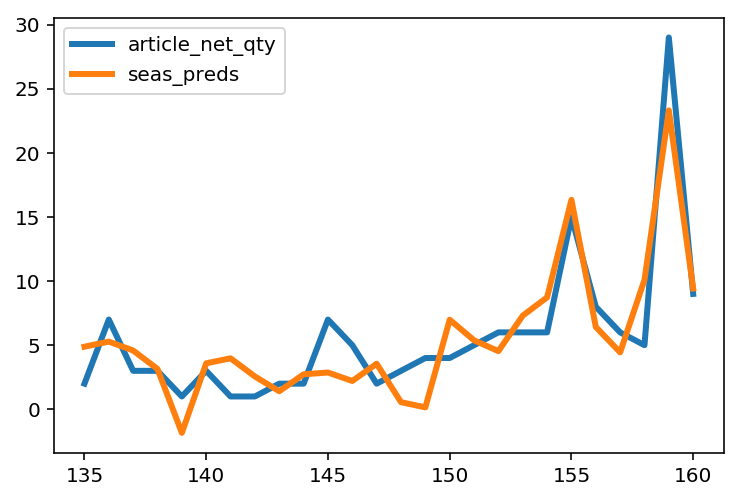

In [146]:
dat_SS19 = dat_SS19_0.drop(['clearance', 'margin', 'gross_demand_quantity', 'season_gross_demand_quantity'], axis = 1).copy()

articles_subset = np.random.choice(articles, size = 10, replace = False)
dat_SS19 = dat_SS19[dat_SS19.article_number.isin(articles_subset)]


seas_preds = dat_SS19.groupby(['article_number']).apply(regress).reset_index().drop('level_1', axis = 1)

dat_SS19.shape
dat_SS19.head()

seas_preds.shape
seas_preds.head()

dat_SS19 = pd.merge(dat_SS19, seas_preds)
dat_SS19.shape

dat_SS19[dat_SS19.article_number == articles_subset[0]].head()
dat_SS19[dat_SS19.article_number == articles_subset[0]][['article_net_qty', 'seas_preds']].plot(linewidth = 3)




# GAS

## $\bar{y}_{\text{ category, level, week}} = f_{\text{c, l, w}} + \epsilon_{\text{ c, l, w}}$


### Functions 

In [29]:
def initialize_parameters_0(par = np.array([0.5, 0.9, 0, 1, 0])):
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]                   

    return parameters


def loglik_0(y, f, sigma):
    ll = -1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - f)**2 
    return ll


def score_compute_0(y, f, parameters, epsilon = 1e-7 ):
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score = (y - f)/sigma
    
    return score


def filterGAS_0(y, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
    
    score0 = score_compute_0(y[0,:],  f0, parameters, epsilon = 1e-7) 
    
    f = np.zeros((len(y),1))
    f[0,:] = f0
    
    for t in range(1,len(y)):
        scoret = score_compute_0(y[t-1,:], f[t-1,:], parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f


def loglikest_0(par, y):
    
    parameters = initialize_parameters_0(par)
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
    
    f = filterGAS_0(y, parameters) 
    ll = np.zeros((len(y), 1))
    m = len(y)

    for t in range(0, len(y)):
         ll[t,:] = loglik_0(y[t,:], f[t,:], sigma)
            
    loglik_res = -(np.sum(ll))/m

    return loglik_res


def GAS_est_0(df):
    
    y = df.iloc[:,-1].values # THIS IS NOT ROBUST. 
    y = y.reshape((len(y),1)) 
    
    ret = pd.DataFrame()
    ret['week'] = df['week']
        
    abc = scipy.optimize.minimize(
        loglikest_0,                                       
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y)]), 
        args = y, 
        options = {'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method ='L-BFGS-B', 
        bounds =((0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2)   # f
               )
    )
    
    if abc.success == False:
        print('Non-convergence', head(df))

    x1par = initialize_parameters_0(abc.x) 
    GAS = filterGAS_0(y, x1par)
    ret['GAS_est'] = GAS

    return ret

In [147]:

seasonality_dfs = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]
net_qty_cols = ['sport_weekly_mean', 'rmh_weekly_mean', 'gender_weekly_mean', 'age_weekly_mean', 'franchise_weekly_mean', 'prd_grp_weekly_mean'] # seasonality_df[<net_qty_by_another_name>] 
categories = ['sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc']

abbrevs = ['sp', 'rmh', 'gndr', 'agegrp', 'frnchse', 'prdgrp']

for i in range(6):
    
    # rename net_qty columns to 'net_qty'    
    if any(seasonality_dfs[i].columns.isin([net_qty_cols[i]])):
        seasonality_dfs[i] = seasonality_dfs[i].rename(columns = {net_qty_cols[i]: 'net_qty'})
    
    # GAS category-level means
    seasonality_dfs[i] = pd.DataFrame(pd.merge(
        seasonality_dfs[i], 
        seasonality_dfs[i].groupby(categories[i]).apply(GAS_est_0).reset_index().drop('level_1', axis = 1)
    )).rename(columns = {'GAS_est': 'GAS_est' + '_' + abbrevs[i]}) # distinct names for GAS_est column
        

In [ ]:
for i in range(6):
    seasonality_dfs[i].head()

In [ ]:
# seasonality_dfs2 = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]

abbrevs = ['sp', 'rmh', 'gndr', 'agegrp', 'frnchse', 'prdgrp']
for i in range(6):
    if any(seasonality_dfs[i].columns.isin(['GAS_est'])):
        seasonality_dfs[i] = seasonality_dfs[i].rename(columns = {'GAS_est': 'GAS_est' + '_' + abbrevs[i]})
        
        

## Multivariate GAS

## $y^{*}_{i,t} = f_{i,t} + \lambda_{sp}f_{sp,i,t} + \lambda_{rmh}f_{rmh,i,t} + ... + \lambda_{gndr}f_{gndr,i,t} + \epsilon_{i,t}$

In [ ]:
def initialize_parameters_mv(par = np.array([0.5, 0.9, 0, 1, 0,
                                             0, 0, 0, 0, 0, 0])):
    parameters = {}

    parameters['alpha'] = par[0]
    parameters['beta'] = par[1]
    parameters['omega'] = par[2]* (1-par[1])
    parameters['sigma'] = par[3]
    parameters['f0'] = par[4]
    
    # l for lambda
    parameters['l_sport'] = par[5]
    parameters['l_rmh'] = par[6]    
    parameters['l_gender'] = par[7]
    parameters['l_age'] = par[8]
    parameters['l_franchise'] = par[9]
    parameters['l_prod_grp'] = par[10]
    
    return parameters


def loglik_mv(y, f, 
              f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, 
              l_sport, l_rmh, l_gender, l_age, l_franchise, l_prod_grp, 
              sigma):
    
    ll = (-1/2*np.log(2*np.pi ) - 1/2*np.log(sigma) - 1/(2*sigma)*(y - (f + l_sport*f_sp + l_rmh*f_rmh + l_gender*f_gndr + l_age*f_age + l_franchise*f_fr + l_prod_grp*f_pr))**2 
    
    return ll


def score_compute_mv(y, f, 
                     f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, 
                     parameters, epsilon = 1e-7):
          
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
          
    l_sport = parameters['l_sport'] 
    l_rmh = parameters['l_rmh'] 
    l_gender = parameters['l_gender'] 
    l_age = parameters['l_age'] 
    l_franchise = parameters['l_franchise'] 
    l_prod_grp = parameters['l_prod_grp']
    
    score = (y - (f + l_sport*f_sp + l_rmh*f_rmh + l_gender*f_gndr + l_age*f_age + l_franchise*f_fr + l_prod_grp*f_pr))/sigma
    
    return score


def filterGAS_mv(y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, parameters):
    
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    omega = parameters['omega']
    sigma = parameters["sigma"]
    f0 = parameters["f0"]
          
    l_sport = parameters['l_sport'] 
    l_rmh = parameters['l_rmh'] 
    l_gender = parameters['l_gender'] 
    l_age = parameters['l_age'] 
    l_franchise = parameters['l_franchise'] 
    l_prod_grp = parameters['l_prod_grp']
    
    score0 = score_compute_mv(y[0,:], f0, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, parameters, epsilon = 1e-7) 
    
    f = np.zeros((len(y),1))
    f[0,:] = f0
    
    for t in range(1,len(y)):
        scoret = score_compute_mv(y[t-1,:], f[t-1,:], f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, parameters, epsilon = 1e-7) 
        f[t,:] = omega + alpha*scoret + beta*f[t-1,:] 

    return f


def loglikest_mv(y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, parameters):
    
    parameters = initialize_parameters_mv(parameters)
          
    alpha = parameters["alpha"]
    beta = parameters["beta"]
    sigma = parameters["sigma"]
          
    l_sport = parameters['l_sport'] 
    l_rmh = parameters['l_rmh'] 
    l_gender = parameters['l_gender'] 
    l_age = parameters['l_age'] 
    l_franchise = parameters['l_franchise'] 
    l_prod_grp = parameters['l_prod_grp']
          
    ll = np.zeros((len(y), 1))
    m = len(y)
          
    f = filterGAS_mv(y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, parameters) 
          
    for t in range(0, len(y)):
         ll[t,:] = loglik_mv(y[t,:], f[t,:], 
                             f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, 
                             l_sport, l_rmh, l_gender, l_age, l_franchise, l_prod_grp, 
                             sigma)
            
    loglik_res = -(np.sum(ll))/m

    return loglik_res

In [103]:
for i in range(6):
    seasonality_dfs[i].head()
    

dat_SS19_test_2[['article_number', 'year', 'week', 'season', 
                 'sports_cat_desc', 'rmh_cat_desc', 'gender_desc', 'age_group_desc', 'franchise', 'prod_grp_desc',
                 'deseas_net_qty']].head()

,sports_cat_desc,week,net_qty
0,AMERICAN FOOTBALL,5.0,82.000000
1,AMERICAN FOOTBALL,6.0,5.000000
2,AMERICAN FOOTBALL,7.0,7.000000
3,BASKETBALL,1.0,14.779006
4,BASKETBALL,2.0,15.320955


,rmh_cat_desc,week,net_qty
0,ACTION SPORTS,1.0,16.607018
1,ACTION SPORTS,2.0,19.549858
2,ACTION SPORTS,3.0,17.741772
3,ACTION SPORTS,4.0,12.548628
4,ACTION SPORTS,5.0,13.715736


,gender_desc,week,net_qty
0,MEN,1.0,22.419275
1,MEN,2.0,24.312762
2,MEN,3.0,21.965517
3,MEN,4.0,17.290423
4,MEN,5.0,15.714167


,age_group_desc,week,net_qty
0,ADULT,1.0,22.608230
1,ADULT,2.0,25.443405
2,ADULT,3.0,23.092557
3,ADULT,4.0,18.333314
4,ADULT,5.0,16.582723


,franchise,week,net_qty
0,25/7 TEE,1.0,11.210526
1,25/7 TEE,2.0,15.012500
2,25/7 TEE,3.0,15.157895
3,25/7 TEE,4.0,9.786667
4,25/7 TEE,5.0,6.464789


,prod_grp_desc,week,net_qty
0,APPAREL ACCESSORIES,1.0,18.519084
1,APPAREL ACCESSORIES,2.0,16.441176
2,APPAREL ACCESSORIES,3.0,16.884892
3,APPAREL ACCESSORIES,4.0,13.381679
4,APPAREL ACCESSORIES,5.0,12.549618


,article_number,year,week,season,sports_cat_desc,rmh_cat_desc,gender_desc,age_group_desc,franchise,prod_grp_desc,deseas_net_qty
0,CP8991,2018.0,49.0,SS19,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,KIDS,X,SHOES,0.193112
1,CP8991,2018.0,50.0,SS19,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,KIDS,X,SHOES,-0.375215
2,CP8991,2019.0,1.0,SS19,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,KIDS,X,SHOES,1.437080
3,CP8991,2019.0,2.0,SS19,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,KIDS,X,SHOES,-2.501703
4,CP8991,2019.0,3.0,SS19,FOOTBALL/SOCCER,FOOTBALL GENERIC,MEN,KIDS,X,SHOES,2.403082


In [104]:

# test = pd.merge(dat_SS19_test_2, seasonality_dfs2[i].drop('net_qty', axis = 1), how = 'left')

# for i in range(1, 6):
#     test = pd.merge(test, seasonality_dfs2[i].drop('net_qty', axis = 1), how = 'left')
#     test.shape
    
# seasonality_dfs2 = [seasonality_sport, seasonality_rmh, seasonality_gndr, seasonality_agegrp, seasonality_frnchse, seasonality_prdgrp]

    
dat_factors = (pd.merge(dat_SS19, seasonality_sport).
      merge(seasonality_rmh).
      merge(seasonality_gndr).
      merge(seasonality_agegrp).
      merge(seasonality_frnchse).
      merge(seasonality_prdgrp).
      drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
            'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))
    

(224, 29)

(224, 30)

(224, 31)

(224, 32)

(224, 32)

In [105]:
dat_factors.head()

,article_number,brand,year,week,country,season,gross_demand_quantity,article_net_qty,clearance,margin,season_gross_demand_quantity,season_net_qty,buy_availability,cost,price,article_no,Year,Week,date,sport_weekly_mean,rmh_weekly_mean,gender_weekly_mean,age_weekly_mean,franchise_weekly_mean,prd_grp_weekly_mean
0,011040,adidas,2018.0,48.0,EU,SS19,1,1,0.0,79.37,161.0,116.0,1.00,40.03,119.40,011040,2018,48,2018-11-26,25.742342,29.605968,31.453349,32.597163,28.576049,30.542954
1,015110,adidas,2018.0,48.0,EU,SS19,3,1,0.0,69.65,998.0,752.0,1.00,33.87,103.52,015110,2018,48,2018-11-26,25.742342,29.605968,31.453349,32.597163,28.576049,30.542954
2,019000,adidas,2018.0,48.0,EU,SS19,14,7,0.0,35.14,1820.0,1244.0,1.00,15.46,50.60,019000,2018,48,2018-11-26,25.742342,29.605968,31.453349,32.597163,28.576049,30.542954
3,019228,adidas,2018.0,48.0,EU,SS19,1,1,0.0,77.24,681.0,419.0,0.67,20.47,97.71,019228,2018,48,2018-11-26,25.742342,29.605968,31.453349,32.597163,28.576049,30.542954
4,019310,adidas,2018.0,48.0,EU,SS19,3,2,0.0,87.79,449.0,270.0,1.00,19.73,107.52,019310,2018,48,2018-11-26,25.742342,29.605968,31.453349,32.597163,28.576049,30.542954


In [101]:
test.iloc[:, -6:] # Where is sport!?!?

,deseas_net_qty,GAS_est_prdgrp,GAS_est_rmh,GAS_est_gndr,GAS_est_agegrp,GAS_est_frnchse
0,0.193112,22.208432,16.690346,19.925621,14.475099,18.619527
1,-0.375215,24.308658,18.043427,21.856389,16.678078,19.740265
2,1.437080,25.109664,16.617037,21.724795,12.759692,17.882461
3,-2.501703,25.469933,16.879021,22.019011,17.022085,18.505045
4,2.403082,26.269971,17.171176,22.465641,17.026027,20.034051
5,-1.525655,24.950448,16.927221,21.639584,16.454108,19.563990
6,-2.255257,23.881790,16.446283,20.570285,15.922656,17.108346
7,0.155414,23.875580,16.121159,20.475250,15.546173,15.967808
8,-1.339396,23.472020,16.078889,20.199016,15.573866,15.126512
9,0.985078,24.128706,16.603749,20.785621,16.171104,16.642981


In [ ]:
# GAS behemoth

def GAS_est_mv(df):
    
    # For article a's level of each category 
        # Retrieve deseasonalized y*
        # Retreive appropriate GAS factors
        # Then apply multi-factor GAS 
        
    ret = pd.DataFrame()
    ret['week'] = df['week']
    
    y = df.deseas_net_qty.values     
    y = y.reshape((len(y),1)) 
    
    f_sp = df.GAS_est_sp.values.reshape((len(y),1)) 
    f_rmh = df.GAS_est_rmh.values.reshape((len(y),1)) 
    f_gndr = df.GAS_est_gndr.values.reshape((len(y),1)) 
    f_age = df.GAS_est_age.values.reshape((len(y),1)) 
    f_fr = df.GAS_est_fr.values.reshape((len(y),1)) 
    f_pr = df.GAS_est_pr.values.reshape((len(y),1)) 
    
    abc = scipy.optimize.minimize(
        loglikest_mv,                                       
        np.array([0.8, 0.9, np.mean(y), 1, np.mean(y), 0, 0, 0, 0, 0, 0]), 
        args = (y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr),
        options = {'eps':1e-09, 'maxiter': 600, 'ftol': 1e-12},
        method ='L-BFGS-B', 
        bounds =(
                (0,  None),             # alpha
                (-1, 1),                # beta
                (0.001, np.mean(y)*2),  # omega 
                (0.001, None),          # sigma
                (0.001, np.mean(y)*2),  # f
                (None, None),           # lambda_sport
                (None, None),           # lambda_rmh
                (None, None),           # lambda_gender
                (None, None),           # lambda_age
                (None, None),           # lambda_franchise
                (None, None),           # lambda_prod_grp
               )
    ) # I NEED TO DOUBLE CHECK THESE CONSTRAINTS
    
    if abc.success == False:
        print('Non-convergence', head(df))
    
    x1par = initialize_parameters_mv(abc.x) 
    GAS = filterGAS_mv(y, f_sp, f_rmh, f_gndr, f_age, f_fr, f_pr, x1par)
          
    ret['deseas_GAS_est'] = GAS
    
    return ret

# Appendix

In [ ]:


for i in range(6):
    seasonality_dfs[i].head()
    seasonality_dfs2[i].head()

In [ ]:
# Add GAS estimates to data
# dat_FW18 = dat_FW18.merge(
#     dat_GAS[['article_number', 'year', 'week', 'GAS_est']], 
#     how = 'left', 
#     on = ['article_number', 'year', 'week']
#                           ).sort_values(['article_number', 'year', 'week'])

# # tidy
# dat_FW18 = dat_FW18[['article_number', 'year', 'week', 'net_qty', 'GAS_est', 'buy_availability', 'prod_grp_desc']]
# seasonality.rename(columns = {'net_qty': 'seasonal_week_avg'}, inplace = True)

In [ ]:
# Two part combine: merge + concatenate

# df = dat_FW18.copy()
# container = pd.DataFrame(data = None, columns = dat_FW18.columns)

# for a in df.article_number.unique():
    
#     dat_a = df[df.article_number == a]
#     seasonality_a = seasonality[seasonality.prod_grp_desc == dat_a.prod_grp_desc.unique()[0]]
    
#     dat_a = pd.merge(dat_a, seasonality_a[['week', 'seasonal_week_avg']], 
#                      how = 'right', 
#                      on = 'week').sort_values('week')
        
#     dat_a[['year', 'article_number', 'prod_grp_desc']] = dat_a[['year', 'article_number', 'prod_grp_desc']].fillna(method='ffill')
#     dat_a[['year', 'article_number', 'prod_grp_desc']] = dat_a[['year', 'article_number', 'prod_grp_desc']].fillna(method='bfill')

#     container = pd.concat([container, dat_a], sort = True)

# dat_FW18 = container.copy()
# del container, df

In [ ]:
#   --- CHOOSE RANDOM ARTICLE TO PLOT---
# a = np.random.choice(dat_FW18.article_number.unique(), size = 1, replace = False)[0]
# a = 'CQ2659'
# dat_a = dat_FW18[dat_FW18.article_number == a].copy()
# # dat_a.sort_values('week', inplace = True)
# # dat_a.set_index(['week'], inplace = True)
# #   ---- ---- ---- ---- ---- ---- 

# plt.rcParams['font.size'] = 22
# plt.rcParams['legend.fontsize'] = 'medium'
# plt.rcParams['figure.titlesize'] = 'medium'
# plt.rcParams["figure.figsize"] = [14,18]

# # Plot 0 -------
# plt.subplot(3,1,1)
# plt.plot(dat_a.index, 
#          dat_a[['GAS_est']], 
#          linewidth = 4, color = 'orange')
# # plt.legend(('GAS_est'))

# plt.xlim((21, 50))
# # plt.title('Net Demand Qty: Observed and GAS Estimated \'True\' ')
# plt.title('Net Demand Qty: GAS Estimated \'True\' ')
# plt.xlabel('Week')
# plt.ylabel('Net Demand Qty')
# plt.grid(True)
# plt.subplots_adjust(hspace = 0.4) ####


# # Plot -------
# plt.subplot(3,1,2)
# plt.plot(dat_a.index, 
#          dat_a[['preds']], 
#          linewidth = 4)
# # plt.legend(('seasonal_week_avg', 'preds'))

# plt.xlim((21, 50))
# # plt.title('Net Demand Qty: Observed, GAS, Seasonality')
# plt.title('Net Demand Qty: Seasonality-based Prediction')

# plt.xlabel('Week')
# plt.ylabel('Net Demand Qty')
# plt.grid(True)
# plt.subplots_adjust(hspace = 0.4) ####



# # Plot -------
# plt.subplot(3,1,3)
# plt.plot(dat_a.index, 
#          pd.concat([dat_a['GAS_est'].loc[22:35], dat_a['preds'].loc[36:49]]), 
#          linewidth = 4, color = 'green')
# # plt.legend(('seasonal_week_avg', 'preds'))

# plt.xlim((21, 50))
# # plt.title('Net Demand Qty: Observed, GAS, Seasonality')
# plt.title('Net Demand Qty: GAS + Seasonality')

# plt.xlabel('Week')
# plt.ylabel('Net Demand Qty')
# plt.grid(True)
# plt.subplots_adjust(hspace = 0.4) ####


# # Plot 2 -------
# plt.subplot(3,1,3)
# plt.plot(dat_a.index, dat_a['buy_availability'], 
#          linewidth = 4, label='buy_availability')
# plt.xlim((21, 50))
# plt.xlabel('Week')
# plt.ylabel('Net Demand Qty')
# plt.title('Buy Availability')
# plt.grid(True)
# plt.subplots_adjust(hspace = 0.4) ####

# plt.legend()

# RED (preds) is GREEN's (article type weekly avg) prediction of ORANGE (GAS)

In [ ]:
# pd.concat([dat_a['GAS_est'].loc[22:35], dat_a['preds'].loc[36:49]])

# dat[(dat.article_number == 'CQ2659') &
#           (dat.country == 'EU') & 
#           (dat.season_net_qty != 0)].sort_values('week')[['week', 'net_qty', 'season_net_qty', 'buy_availability']]

# dat_a 

# dat_a.buy_availability.iloc[16]
# type(dat_a.buy_availability.iloc[16])

# is_nan(dat_a.buy_availability.iloc[16])



In [ ]:
# # ---- for article a's level of each attribute, calculate weekly means -----
    
# # article a
# dat_a = dat_SS19[dat_SS19.article_number == a]

# # article 'a' net_demand_qty
# y = dat_a[['article_net_qty', 'week']].set_index('week')

# # article 'a' category-level weekly means
# # set_index() for joining
# x_sport   = seasonality_sport[seasonality_sport.sports_cat_desc == dat_a.sports_cat_desc.unique()[0]].set_index('week')
# x_rmh     = seasonality_rmh[seasonality_rmh.rmh_cat_desc == dat_a.rmh_cat_desc.unique()[0]].set_index('week')
# x_gndr    = seasonality_gndr[seasonality_gndr.gender_desc == dat_a.gender_desc.unique()[0]].set_index('week')
# x_agegrp  = seasonality_agegrp[seasonality_agegrp.age_group_desc == dat_a.age_group_desc.unique()[0]].set_index('week')
# x_frnchse = seasonality_frnchse[seasonality_frnchse.franchise == dat_a.franchise.unique()[0]].set_index('week')
# x_prdgrp  = seasonality_prdgrp[seasonality_prdgrp.prod_grp_desc == dat_a.prod_grp_desc.unique()[0]].set_index('week')

# # design matrix (ensure 'week' alignment)
# yX = (pd.merge(y, x_sport, left_index=True, right_index=True).
#      merge(x_rmh, left_index=True, right_index=True).
#      merge(x_gndr, left_index=True, right_index=True).
#      merge(x_agegrp, left_index=True, right_index=True).
#      merge(x_frnchse, left_index=True, right_index=True).
#      merge(x_prdgrp, left_index=True, right_index=True).
#      drop(['sports_cat_desc', 'rmh_cat_desc', 'gender_desc',
#            'age_group_desc', 'franchise', 'prod_grp_desc'], axis = 1))

# # predict article 'a' net_demand_qty with 5 article a category-level seasonalities
# mod = sm.OLS(yX.article_net_qty, yX.drop('article_net_qty', axis = 1), missing='drop').fit()

# mod.predict()
# print(mod.summary())

In [ ]:
# ----- seasonal_decompose approach ------

# seasonality_dat = dat[(dat.season_net_qty > 100)] 
                    
# seasonality_sport   = pd.DataFrame(seasonality_dat.groupby(['sports_cat_desc', 'date'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})
# seasonality_rmh     = pd.DataFrame(seasonality_dat.groupby(['rmh_cat_desc', 'date'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'rmh_weekly_mean'})
# seasonality_gndr    = pd.DataFrame(seasonality_dat.groupby(['gender_desc', 'date'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'gender_weekly_mean'})
# seasonality_agegrp  = pd.DataFrame(seasonality_dat.groupby(['age_group_desc', 'date'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'age_weekly_mean'})
# seasonality_frnchse = pd.DataFrame(seasonality_dat.groupby(['franchise', 'date'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'franchise_weekly_mean'})
# seasonality_prdgrp  = pd.DataFrame(seasonality_dat.groupby(['prod_grp_desc', 'date'])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'prd_grp_weekly_mean'})



# ---- ---- my function ---- -----

# def seas_decomp(df):
    
#     ret = pd.DataFrame()
#     ret['date'] = df['date']
    
#     if df.sport_weekly_mean.shape[0] < 52:
#         ret['seas'] = np.nan
#     else:
#         decomp = seasonal_decompose(df.sport_weekly_mean, model = 'additive', freq = 52, extrapolate_trend = 'freq')
#         ret['seas'] = decomp.seasonal
        
#     return ret


# ---- ---- Benoit troubleshooting ---- ----

# for g in seasonality_sport.groupby('sports_cat_desc'):
#     break

# test = g[1].sport_weekly_mean.values
# test.shape

# seasonal_decompose(test, model = 'additive', freq = 1, extrapolate_trend = 'freq')

# for i in np.arange(3,200):
#     try:
#         seasonal_decompose(np.random.randn(i,), model = 'additive', freq = 52, extrapolate_trend = 'freq')
#     except ValueError:
#         print(i)



# ---- ---- time series shenanigans ---- ----

# seasonality_sport_ts   = pd.DataFrame(seasonality_sport.groupby(['sports_cat_desc', dat_ts.index])['net_qty'].mean()).reset_index().rename(columns = {'net_qty': 'sport_weekly_mean'})

basketball = seasonality_sport[seasonality_sport.sports_cat_desc == 'BASKETBALL']

basketball = basketball.set_index('date')

# detrend(basketball.sport_weekly_mean)

seas_decomp = seasonal_decompose(basketball.sport_weekly_mean, model = 'additive', freq = 52, extrapolate_trend = 'freq')

# fig = seas_decomp.plot()
# fig.set_size_inches(15, 8)

# pd.DataFrame(seas_decomp.seasonal)
# seas_decomp.trend
# seas_decomp.resid
# seas_decomp.observed



In [ ]:

#   --- RANDOM SUBSET OF ARTICLES ---
dat_FW18.set_index(['article_number'], inplace = True)
a = np.random.choice(dat_FW18.index.unique(), size = 100, replace = False)
# dat_FW18 = dat_FW18.loc[np.append(a, ['D96635']) ,:].copy() 
dat_FW18 = dat_FW18.loc[a ,:].copy()
dat_FW18.reset_index(inplace = True)
#   ---- ---- ---- ---- ---- ---- 

In [ ]:
# GAS: e.g. basketball = f_b + eps

# seasonality_sport = seasonality_sport.rename(columns = {'sport_weekly_mean': 'net_qty'})
# seasonality_sport.groupby('sports_cat_desc').apply(GAS_est_0).reset_index()

# seasonality_sport_GAS = seasonality_sport_GAS.reset_index()

# seasonality_sport2 = pd.merge(seasonality_sport, seasonality_sport_GAS[['sports_cat_desc', 'week', 'GAS_est']])

In [6]:
# dat['Year'] = [str(x)[:-2] for x in dat.year]
# dat['Week'] = [str(x)[:-2] for x in dat.week]

# dat['date'] = [dt.datetime.strptime(x[0] + '-' + x[1] + '-1', "%Y-%W-%w") for x in zip(dat.Year, dat.Week)]


In [ ]:
# for c in ref_dat.columns:
#     print(c, len(ref_dat[c].unique()))
#     # print(ref_dat[c].unique())
#     print()

# pd.crosstab(index = [dat['prod_grp_desc']], columns = 'count')